# Source Detection

In [1]:
from karabo.imaging import imager
from karabo.simulation.telescope import Telescope
from karabo.simulation.observation import Observation
from karabo.simulation.interferometer import InterferometerSimulation
from karabo.simulation.sky_model import SkyModel
from karabo.sourcedetection.result import SourceDetectionResult
from karabo.sourcedetection.evaluation import SourceDetectionEvaluation

# Render plots inline
%matplotlib inline

/home/vincenzo/miniconda3/envs/karabo_dev_env/data/
/home/vincenzo/miniconda3/envs/karabo_dev_env/data/


## Simulation

/home/vincenzo/Karabo-Pipeline/karabo/simulation/sky_model.py:422: RuntimeWarning: invalid value encountered in log10
  log_flux = np.log10(flux)


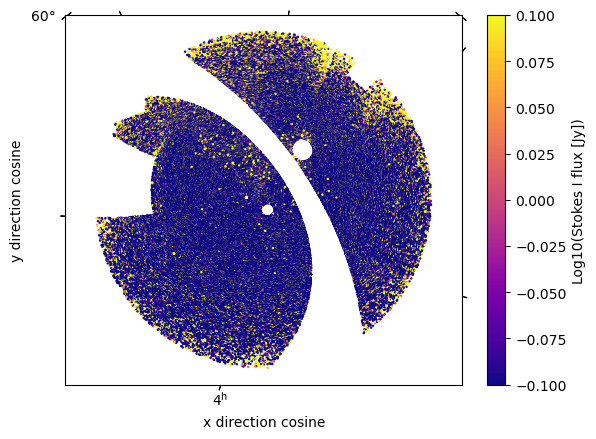

In [2]:
# Get GLEAM Survey Sky
phase_center = [250, -80]
gleam_sky = SkyModel.get_GLEAM_Sky()
gleam_sky.plot_sky(phase_center)

Then we filter the sky model based on radius.

In [3]:
sky = gleam_sky.filter_by_radius(0, .55, phase_center[0], phase_center[1])
sky.setup_default_wcs(phase_center=phase_center)

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---AIR'  'DEC--AIR'  
CRVAL : 250.0  -80.0  
CRPIX : 0.0  0.0  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : -1.0  1.0  
NAXIS : 0  0

Let's have a closer look with the 2d image project explore_sky() provides.

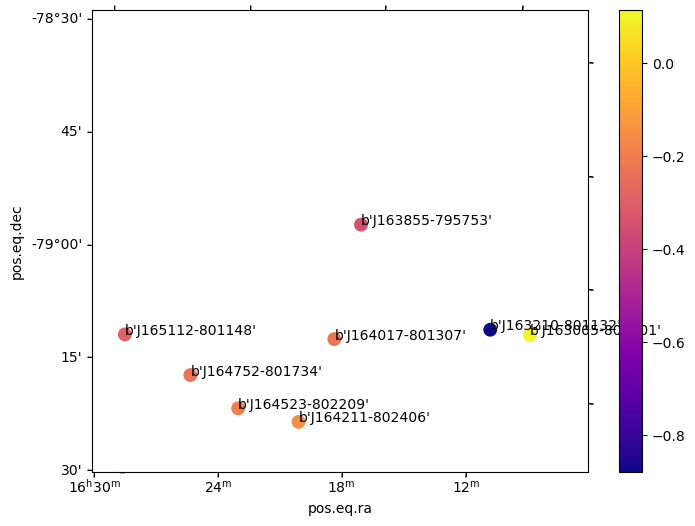

In [4]:
sky.explore_sky(phase_center=phase_center, figsize=(8, 6), s=80,
                xlim=(-.55, .55), ylim=(-.55, .55), with_labels=True)

### Telescope Module

Various observation parameters and meta information `params` must be passed to the telescope module `oskar.Interferometer` of OSKAR as `oskar.SettingsTree`.

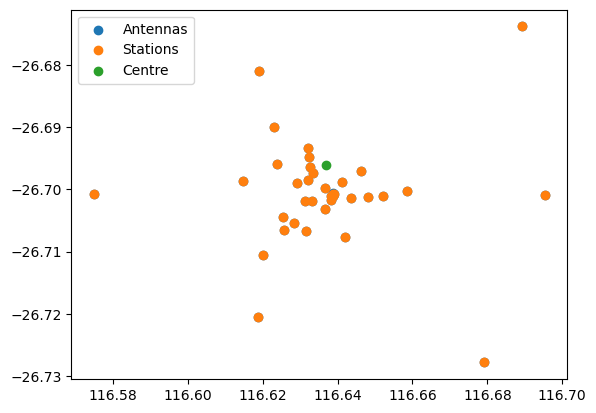

In [5]:
askap_tel = Telescope.get_ASKAP_Telescope()
askap_tel.plot_telescope()

### Observation Simulation

Now the sky module must be passed to the interferometer and the simulation of the observation must be started to generate the measurement set.

In [6]:
observation_settings = Observation(
    start_frequency_hz=100e6,
    phase_centre_ra_deg=phase_center[0],
    phase_centre_dec_deg=phase_center[1],
    number_of_channels=64,
    number_of_time_steps=24
    )

interferometer_sim = InterferometerSimulation(channel_bandwidth_hz=1e6)
visibility_askap = interferometer_sim.run_simulation(askap_tel, sky, observation_settings)

W|                                                                   
W|== WARNING: No GPU capability available.
W|                                                                   


### Dirty Images

We can create dirty images of visibilites and display them as shown below

WCS Keywords

Number of WCS axes: 4
CTYPE : 'RA---SIN'  'DEC--SIN'  'STOKES'  'FREQ'  
CRVAL : 250.0  -80.0  1.0  100000000.0  
CRPIX : 1025.0  1025.0  1.0  1.0  
PC1_1 PC1_2 PC1_3 PC1_4  : 1.0  0.0  0.0  0.0  
PC2_1 PC2_2 PC2_3 PC2_4  : 0.0  1.0  0.0  0.0  
PC3_1 PC3_2 PC3_3 PC3_4  : 0.0  0.0  1.0  0.0  
PC4_1 PC4_2 PC4_3 PC4_4  : 0.0  0.0  0.0  1.0  
CDELT : -0.0022222222222222  0.0022222222222222  1.0  1.0  
NAXIS : 2048  2048  1  64


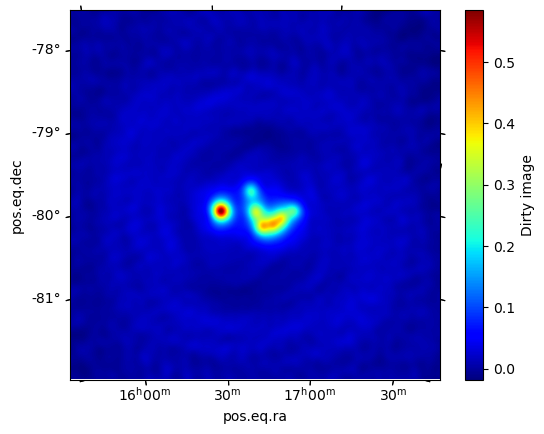

In [7]:
imager_askap = imager.Imager(visibility_askap, imaging_npixel=2048,
                             imaging_cellsize=3.878509448876288e-05)
dirty = imager_askap.get_dirty_image()
dirty.plot(title='Dirty image')

### Source Detection

In [8]:
detection_result_dirty = SourceDetectionResult.detect_sources_in_dirty_image(imager_askap)

2022-10-24 12:06:54,502 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-svz2gm4e', purging
2022-10-24 12:06:54,502 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-d0dmjno9', purging
2022-10-24 12:06:54,502 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-6ogxfp0l', purging
2022-10-24 12:06:54,503 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-wrc845_z', purging
2022-10-24 12:06:54,503 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-deavqg5t', purging


Client Dashboard Address: http://127.0.0.1:8787/status
LocalCluster(4b9a3b89, 'tcp://127.0.0.1:42477', workers=5, threads=5, memory=31.19 GiB)


--> Opened '/home/vincenzo/Karabo-Pipeline/karabo/examples/.tmp/fb46f5f4-a836-4172-b373-b817cfb6c024'
Image size .............................. : (2048, 2048) pixels
Number of channels ...................... : 64
Number of Stokes parameters ............. : 1
Beam shape (major, minor, pos angle) .... : (6.80762e-02, 6.26186e-02, -20.2) degrees
--> Channels averaged with uniform weights
--> Source extraction will be done on averaged ("ch0") image
Frequency of averaged image ............. : 100.000 MHz
Number of blank pixels .................. : 0 (0.0%)
Flux from sum of (non-blank) pixels ..... : 64.876 Jy
--> Calculating background rms and mean images
Derived rms_box (box size, step size) ... : (1691, 205) pixels
--> Size of rms_box larger than 1/4 of image size
--> Using constant background rms and mean
Value of background rms ................. : 8.87e-03 Jy/beam
Value of background mean ................ : 0.00894 Jy/beam
--> Expected 5-sigma-clipped false detection rate < fdr_ratio
--

Fitting islands with Gaussians .......... : [|] 0/1Fitting islands with Gaussians .......... : [] 1/1[-3G

Total number of Gaussians fit to image .. : 6
Total flux density in model ............. : 15.221 Jy


--> Grouping Gaussians into sources
Number of sources formed from Gaussians   : 4


--> Wrote ASCII file '/home/vincenzo/Karabo-Pipeline/karabo/examples/.tmp/d3e469bf-fdaf-4778-b034-a177afac5681'
--> Wrote file '/home/vincenzo/Karabo-Pipeline/karabo/examples/.tmp/0c9408d3-f151-4b1c-a2a0-0c655c0c3f0d'


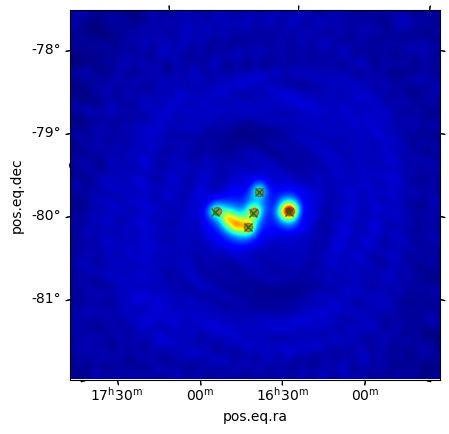

In [9]:
# Create mapping plots
mapping = SourceDetectionEvaluation.evaluate_result_with_sky_in_pixel_space(detection_result_dirty, sky, 10)
mapping.plot()

### Imaging
Of course, we can also do source detection on cleaned (clean algorithmus by rascil) images.

In [10]:
imager_askap.ingest_chan_per_blockvis = 1
imager_askap.ingest_vis_nchan = 16

# Try differnet algorithm
# More sources
deconvolved, restored, residual = imager_askap.imaging_rascil(
    clean_nmajor=0,
    clean_algorithm='mmclean',
    clean_scales=[0, 6, 10, 30, 60],
    clean_fractional_threshold=.3,
    clean_threshold=.12e-3,
    clean_nmoment=5,
    clean_psf_support=640,
    clean_restored_output='integrated')

Client Dashboard Address: http://127.0.0.1:8787/status
LocalCluster(4b9a3b89, 'tcp://127.0.0.1:42477', workers=5, threads=5, memory=31.19 GiB)


## Analysis via Source Detection

Source Detection on restored image.

In [11]:
detection_result = SourceDetectionResult.detect_sources_in_image(restored)

--> Opened '/home/vincenzo/Karabo-Pipeline/karabo/examples/.tmp/fe1d3a71-dec4-48e1-b3a9-5411922eba7d'
Image size .............................. : (2048, 2048) pixels
Number of channels ...................... : 1
Number of Stokes parameters ............. : 1
Beam shape (major, minor, pos angle) .... : (6.80762e-02, 6.26186e-02, -20.2) degrees
Frequency of image ...................... : 100.000 MHz
Number of blank pixels .................. : 0 (0.0%)
Flux from sum of (non-blank) pixels ..... : 28.740 Jy
--> Calculating background rms and mean images
Derived rms_box (box size, step size) ... : (2741, 205) pixels
--> Size of rms_box larger than 1/4 of image size
--> Using constant background rms and mean
Value of background rms ................. : 3.27e-03 Jy/beam
Value of background mean ................ : 0.00335 Jy/beam
--> Expected 5-sigma-clipped false detection rate < fdr_ratio
--> Using sigma-clipping ('hard') thresholding
Minimum number of pixels per island ..... : 326
Number of is

Fitting islands with Gaussians .......... : [|] 0/1Fitting islands with Gaussians .......... : [] 1/1[-3G

Total number of Gaussians fit to image .. : 11
Total flux density in model ............. : 6.915 Jy


--> Grouping Gaussians into sources
Number of sources formed from Gaussians   : 7


--> Wrote ASCII file '/home/vincenzo/Karabo-Pipeline/karabo/examples/.tmp/2c6e3425-da0b-4745-9d9c-e47c1aa7ba2e'
--> Wrote file '/home/vincenzo/Karabo-Pipeline/karabo/examples/.tmp/ab27363e-7825-4f1c-82ea-8d617ec482b5'


## Evaluation

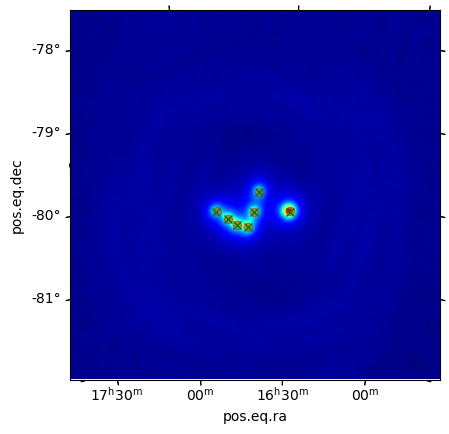

In [12]:
# Create mapping plots
mapping = SourceDetectionEvaluation.evaluate_result_with_sky_in_pixel_space(detection_result, sky, 10)
mapping.plot()

In [13]:
# Confusion Matrix
mapping.get_confusion_matrix()

array([[7., 1.],
       [4., 0.]])

# Make plots clearer.

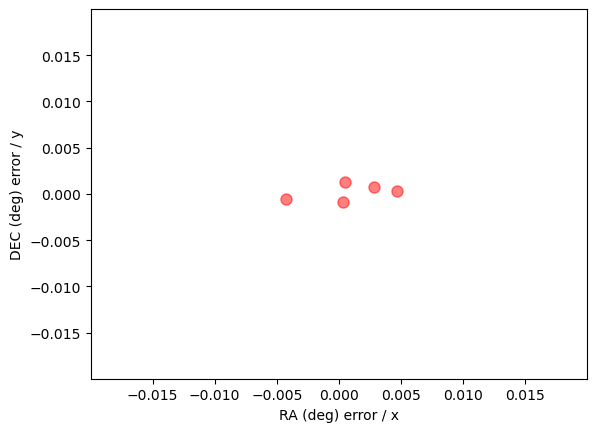

In [14]:
# Plot error ra and dec
mapping.plot_error_ra_dec()

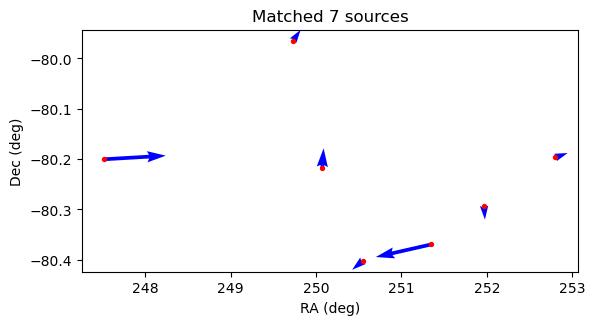

In [15]:
# Plot error flux
mapping.plot_quiver_positions()

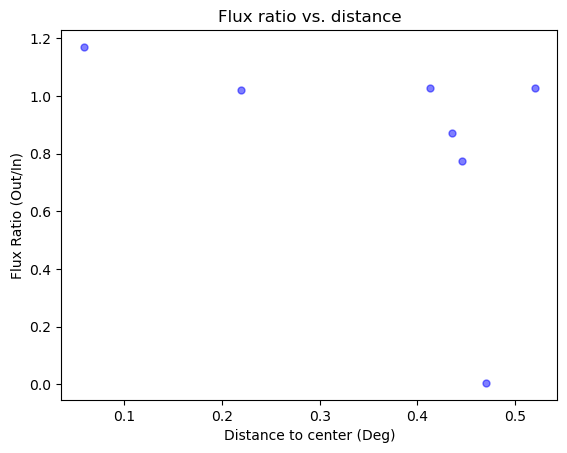

In [16]:
# Plot error ra and dec
mapping.plot_flux_ratio_to_distance()

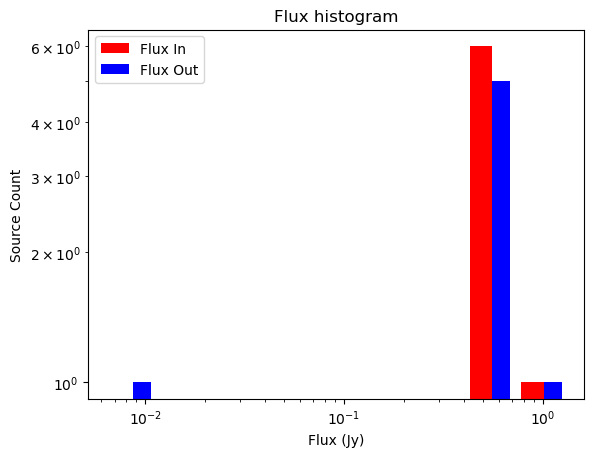

In [17]:
# Plot error ra and dec
mapping.plot_flux_histogram()

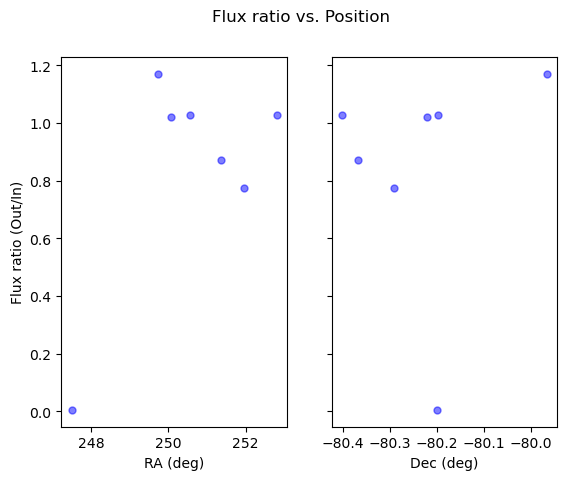

In [18]:
# Plot error ra and dec
mapping.plot_flux_ratio_to_ra_dec()